### EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta

In [2]:
data = pd.read_csv('./data/training.csv')
data

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95657,TransactionId_89881,BatchId_96668,AccountId_4841,SubscriptionId_3829,CustomerId_3078,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-1000.0,1000,2019-02-13T09:54:09Z,2,0
95658,TransactionId_91597,BatchId_3503,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2019-02-13T09:54:25Z,2,0
95659,TransactionId_82501,BatchId_118602,AccountId_4841,SubscriptionId_3829,CustomerId_3874,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2019-02-13T09:54:35Z,2,0
95660,TransactionId_136354,BatchId_70924,AccountId_1346,SubscriptionId_652,CustomerId_1709,UGX,256,ProviderId_6,ProductId_19,tv,ChannelId_3,3000.0,3000,2019-02-13T10:01:10Z,2,0


In [3]:
data['ProductCategory'].unique()

array(['airtime', 'financial_services', 'utility_bill', 'data_bundles',
       'tv', 'transport', 'ticket', 'movies', 'other'], dtype=object)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

In [5]:
data.describe()

,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000


In [6]:
np.mean(abs(data['Amount']) - data['Value'])

-43.47404925675817

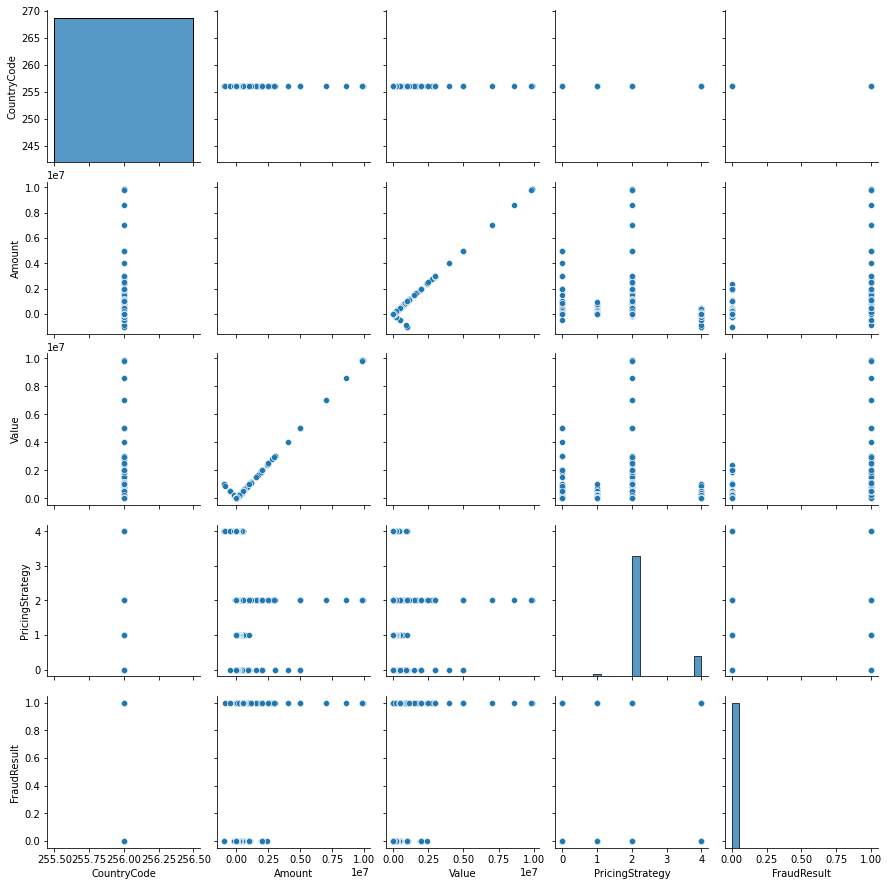

In [7]:
sns.pairplot(data)

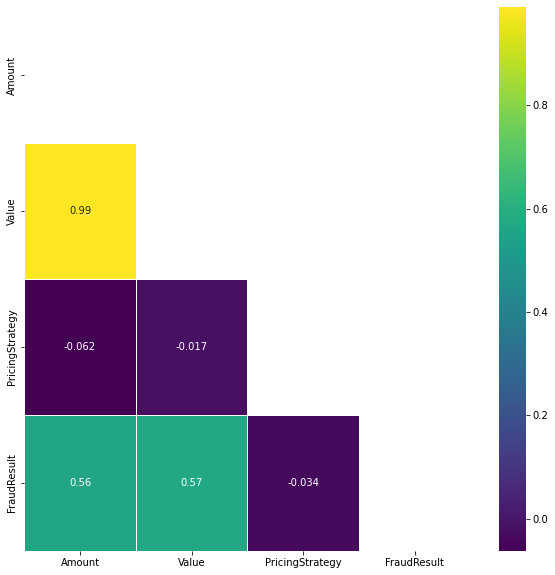

In [8]:
#plotting the correlation matrix on the given data to see how each column correlates to another
fraud_data = data.drop(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode', 'CountryCode'], axis = 1)
plt.figure(figsize=(10, 10))
matrix = np.triu(fraud_data.corr())
sns.heatmap(fraud_data.corr(), annot=True,
            linewidth=.8, mask=matrix, cmap="viridis");

In [9]:
#Convert time to datatime format
data['TransactionStartTime'] = pd.to_datetime(data['TransactionStartTime'], format='%Y-%m-%dT%H:%M:%SZ')
data['Hour'] = data['TransactionStartTime'].dt.hour
data

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,Hour
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49,2,0,2
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08,2,0,2
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21,2,0,2
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55,2,0,3
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95657,TransactionId_89881,BatchId_96668,AccountId_4841,SubscriptionId_3829,CustomerId_3078,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-1000.0,1000,2019-02-13 09:54:09,2,0,9
95658,TransactionId_91597,BatchId_3503,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2019-02-13 09:54:25,2,0,9
95659,TransactionId_82501,BatchId_118602,AccountId_4841,SubscriptionId_3829,CustomerId_3874,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2019-02-13 09:54:35,2,0,9
95660,TransactionId_136354,BatchId_70924,AccountId_1346,SubscriptionId_652,CustomerId_1709,UGX,256,ProviderId_6,ProductId_19,tv,ChannelId_3,3000.0,3000,2019-02-13 10:01:10,2,0,10


In [10]:
#Creating a new variable
data.loc[data['Amount'] >= 0, 'DirectionOfMoney'] = 1
data.loc[data['Amount'] < 0, 'DirectionOfMoney'] = 0
data

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,Hour,DirectionOfMoney
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49,2,0,2,1.0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08,2,0,2,0.0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21,2,0,2,1.0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55,2,0,3,1.0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21,2,0,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95657,TransactionId_89881,BatchId_96668,AccountId_4841,SubscriptionId_3829,CustomerId_3078,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-1000.0,1000,2019-02-13 09:54:09,2,0,9,0.0
95658,TransactionId_91597,BatchId_3503,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2019-02-13 09:54:25,2,0,9,1.0
95659,TransactionId_82501,BatchId_118602,AccountId_4841,SubscriptionId_3829,CustomerId_3874,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2019-02-13 09:54:35,2,0,9,0.0
95660,TransactionId_136354,BatchId_70924,AccountId_1346,SubscriptionId_652,CustomerId_1709,UGX,256,ProviderId_6,ProductId_19,tv,ChannelId_3,3000.0,3000,2019-02-13 10:01:10,2,0,10,1.0


In [11]:
#Creating the final dataset
cat_var = ['PricingStrategy', 'ProviderId', 'ProductId', 'ChannelId', 'ProductCategory', 'Hour', 'DirectionOfMoney']
con_variables = ['Value']
features_cat = pd.get_dummies(data[cat_var])
features_cat
df = data[con_variables].merge(features_cat, left_index=True, right_index=True, how='inner')
df

,Value,PricingStrategy,Hour,DirectionOfMoney,ProviderId_ProviderId_1,ProviderId_ProviderId_2,ProviderId_ProviderId_3,ProviderId_ProviderId_4,ProviderId_ProviderId_5,ProviderId_ProviderId_6,...,ChannelId_ChannelId_5,ProductCategory_airtime,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill
0,1000,2,2,1.0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1,20,2,2,0.0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,500,2,2,1.0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,21800,2,3,1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,644,2,3,0.0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95657,1000,2,9,0.0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
95658,1000,2,9,1.0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
95659,20,2,9,0.0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
95660,3000,2,10,1.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [12]:
#defining X and y
X = df
y = data['FraudResult']

In [16]:
data.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult', 'Hour',
       'DirectionOfMoney'],
      dtype='object')

/Users/kw/neuefische/fraud/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kw/neuefische/fraud/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kw/neuefische/fraud/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

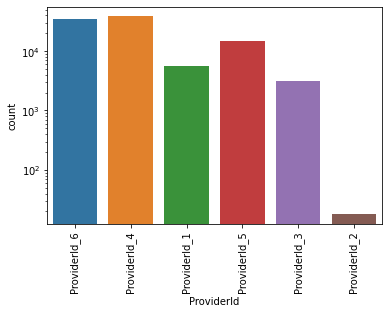

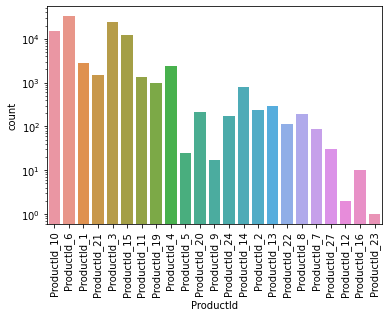

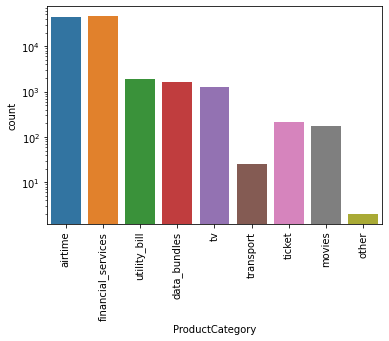

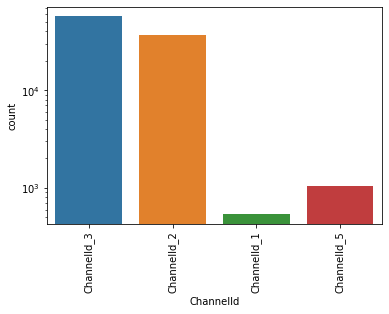

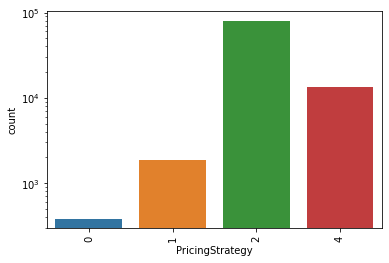

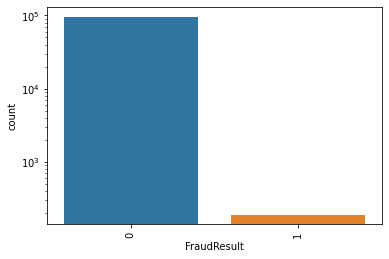

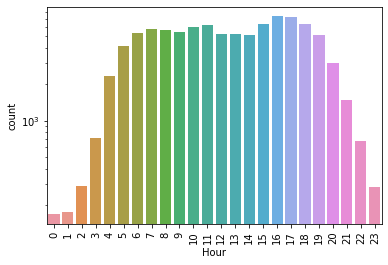

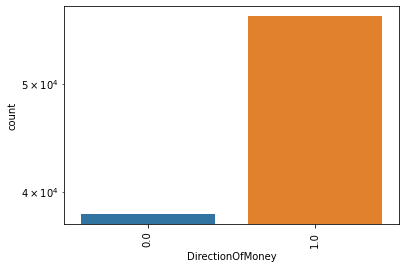

In [32]:
# univariate distributions
for c in data[['ProviderId', 'ProductId','ProductCategory', 'ChannelId','PricingStrategy', 'FraudResult', 'Hour','DirectionOfMoney']].columns:
        plt.figure()
        sns.countplot(data[c])
        plt.xticks(rotation=90)
        plt.yscale('log')


#sns.countplot(data[''])

In [38]:
data.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult', 'Hour',
       'DirectionOfMoney'],
      dtype='object')

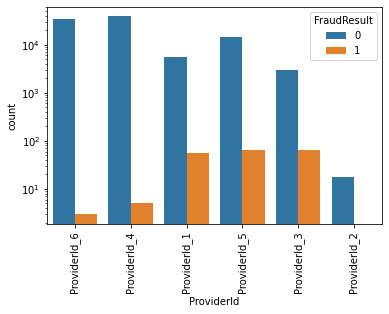

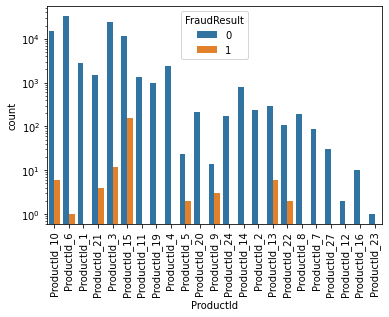

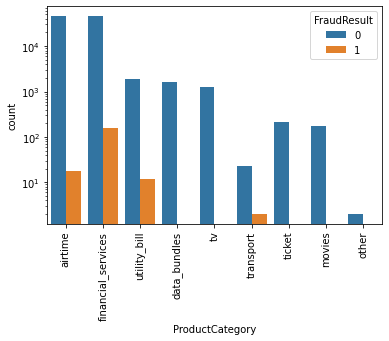

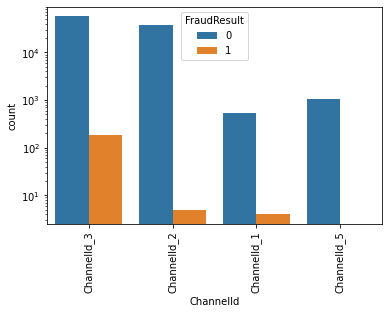

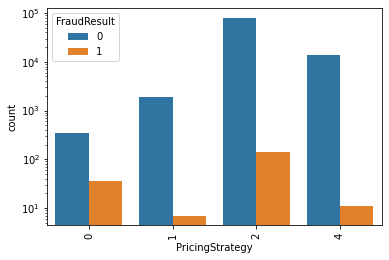

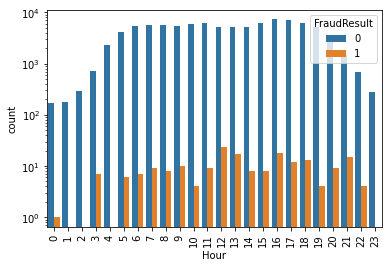

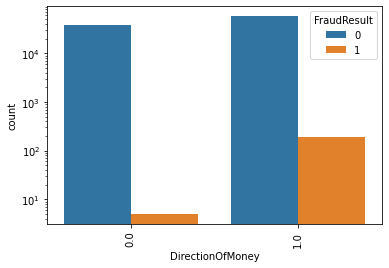

In [41]:
# bivartiate distrobution
for c in data[['ProviderId', 'ProductId','ProductCategory', 'ChannelId','PricingStrategy', 'Hour','DirectionOfMoney']].columns:
        plt.figure()
        #g = sns.FacetGrid(data = data,  col = 'FraudResult')
        sns.countplot(x=c, hue='FraudResult', data = data)
        #g.map(sns.countplot, x = c)
        plt.xticks(rotation=90)
        plt.yscale('log')

#g = sns.FacetGrid(data[['ProviderId', 'ProductId','ProductCategory', 'ChannelId','PricingStrategy', 'FraudResult', 'Hour','DirectionOfMoney', 'FraudResult']], 
#'FraudResult')
#g.map(sns.catplot, 


(array([1.4000e+01, 2.6000e+01, 5.7000e+01, 1.1890e+03, 4.8650e+03,
        1.8600e+03, 9.6280e+03, 3.5570e+03, 1.4420e+03, 1.3560e+03,
        6.4070e+03, 2.0190e+03, 2.2554e+04, 7.1370e+03, 3.0040e+03,
        1.1236e+04, 1.0312e+04, 2.7300e+03, 3.7980e+03, 1.0710e+03,
        4.6600e+02, 4.3500e+02, 1.6900e+02, 9.2000e+01, 9.8000e+01,
        6.4000e+01, 3.4000e+01, 2.0000e+01, 1.4000e+01, 8.0000e+00]),
 array([ 0.69314718,  1.20690971,  1.72067224,  2.23443477,  2.7481973 ,
         3.26195983,  3.77572236,  4.28948489,  4.80324742,  5.31700995,
         5.83077248,  6.34453501,  6.85829754,  7.37206007,  7.8858226 ,
         8.39958513,  8.91334765,  9.42711018,  9.94087271, 10.45463524,
        10.96839777, 11.4821603 , 11.99592283, 12.50968536, 13.02344789,
        13.53721042, 14.05097295, 14.56473548, 15.07849801, 15.59226054,
        16.10602307]),
 <BarContainer object of 30 artists>)

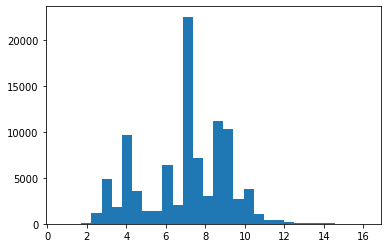

In [56]:
plt.hist(np.log(data.Value), bins = 30)
#histplot()

In [ ]:
df['error'] = abs(df['Amount']) - df['Value']

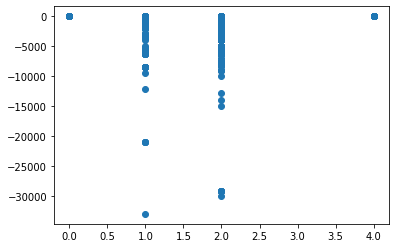

In [ ]:
plt.scatter(df['PricingStrategy'], df['error'])